# Segmentación semantica usando red neuronal convolucional

La segmentación semantica consiste en clasificar cada uno de los pixeles de una imagen en distintas clases.  

https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge/home

http://groups.csail.mit.edu/vision/datasets/ADE20K/

### Acerca del dataset

El conjunto de imagenes que se usará lo provee https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge/home, el cual consiste de 5000 imagenes.

Cada una de las imagenes tiene un tamaño de 600x800, donde se juntan la imagen original y su respectiva máscara de segmentación semántica.

En la máscara de segmentación semántica 13 clases:

1. Construcciones
2. Cercas
3. Otros
4. Peatones 
5. Postes 
6. Lineas de la carretera
7. Carretera
8. Banqueta
9. Vegetación
10. Vehículos
11. Paredes
12. Señal de tráfico

In [2]:
import os
import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from skimage import img_as_float, img_as_ubyte
%matplotlib inline

In [3]:
# Conversion de etiquetas a colores RGB
label2color = {
    0: (0, 0, 0),
    1: (70, 70, 70),
    2: (190, 153, 153),
    3: (250, 170, 160),
    4: (220,  20,  60), 
    5: (153, 153, 153), 
    6: (153, 153, 153), 
    7: (128, 64, 128), 
    8: (244, 35, 232),
    9: (107, 142, 35), 
    10: (0, 0, 142), 
    11: (102, 102, 156), 
    12:(220, 220, 0)
}

In [ ]:
data_imgs = []
data_targets = []

width = 512
height = 512

path = '/floyd/input/image_dataset/dataset/'
img_names = os.listdir(path + 'data')
target_names = os.listdir(path + 'targets')

for img, target in zip(img_names[:3500], target_names[:3500]):
    im = cv2.imread(path + 'data/' + img, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (height, width), interpolation=cv2.INTER_NEAREST)
    data_imgs.append(im)
    im = cv2.imread(path + 'targets/' + img, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (height, width), interpolation=cv2.INTER_NEAREST)
    data_targets.append(im)
    
data_imgs = np.array(data_imgs)
data_targets = np.array(data_targets)

In [4]:
def label2image(img, num_classes=13, height=512, width=512):
    '''
        Toma como entrada una imagen con los valores de las clases 
        en cada pixel y regresa su representacion en colores RGB 
        para poder visualizar la segmentacion semantica.
    '''
    color_mask = np.zeros((height, width, 3), np.uint8())
    for i in range(0, num_classes):
        B, G = np.where(img==i) 
        for r, c in zip(B, G):
            red, green, blue = label2color[i]
            color_mask[r,c,0] = red
            color_mask[r,c,1] = green
            color_mask[r,c,2] = blue
    return color_mask

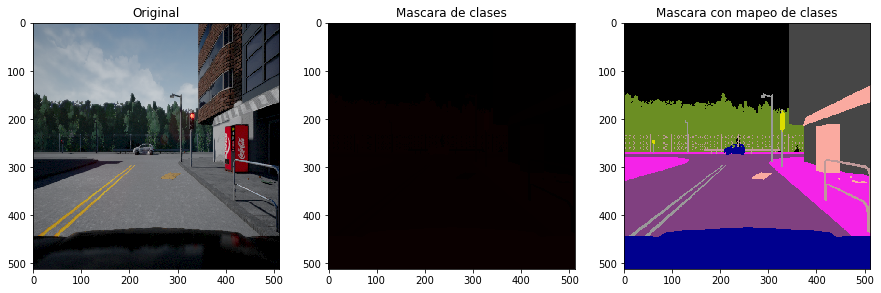

In [5]:
fig = plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(data_imgs[0])
plt.title('Original')
plt.subplot(132)
plt.title('Mascara de clases')
plt.imshow(data_targets[0])
plt.subplot(133)
plt.imshow(label2image(data_targets[0][:,:,0]))
plt.title('Mascara con mapeo de clases')
plt.show()
fig.savefig('test.png')

## Codificacion de las imagenes target

La entrada de la red neuronal convolucional es un tensor con dimensiones (height, widht, 3), la salida es un tensor con dimensiones (height, width, 12).

En este dataset, la imagen objetivo tiene las etiquetas de cada pixel codificadas en el canal rojo (como números enteros del 1 al 12), por lo que en principo tiene dimensiones (height, width, 3). Para que la red neuronal pueda ser entrenada, es necesario codificar la imagen objetivo o tensor con dimensiones (height, width, 12). 

One hot encoding es usado para codificar la imagen objetivo original en un tensor donde cada canal indica con 1's la clase de cada pixel.

In [6]:
#Image(filename="imgs/target_encoding.png", height=600, width=900)

In [7]:
#print('One hot encoding')
#Image(filename="imgs/one_hot.png", height=500, width=900)

In [8]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [9]:
def one_hot_encode(imgs, height=512, width=512):
    one_hot = []
    for i in range(len(imgs)):
        im_class = to_categorical(imgs[i][:,:,0], dtype='uint8')
        if im_class.shape[2] < 13:
            while im_class.shape[2] < 13:
                zeros = np.zeros((height, width, 1), dtype='uint8')
                im_class = np.concatenate((im_class, zeros), axis=2)
        one_hot.append(im_class)
    return np.array(one_hot)

In [10]:
def make_mask(img):
    '''
        Entrada: Tensor de dimensiones (height, width, classes)
        Salida: Tensor de dimensiones (height, width)
        Se mapea la salida de la red neuronal a una sola matriz
        la cual contiene las clases de cada pixel. 
    '''
    return np.argmax(img, axis=-1)

In [11]:
targets_oneHot = one_hot_encode(data_targets)

(512, 512, 13)
(512, 512)
[[ 0  0  0 ...  1  1  1]
 [ 0  0  0 ...  1  1  1]
 [ 0  0  0 ...  1  1  1]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


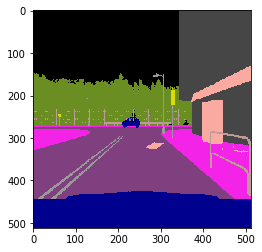

In [12]:
xx = targets_oneHot[0]
print(xx.shape)

yy = make_mask(xx)
print(yy.shape)

print(yy)

plt.figure()
plt.imshow(label2image(yy))
plt.show()

In [13]:
targets_oneHot.shape

(3500, 512, 512, 13)

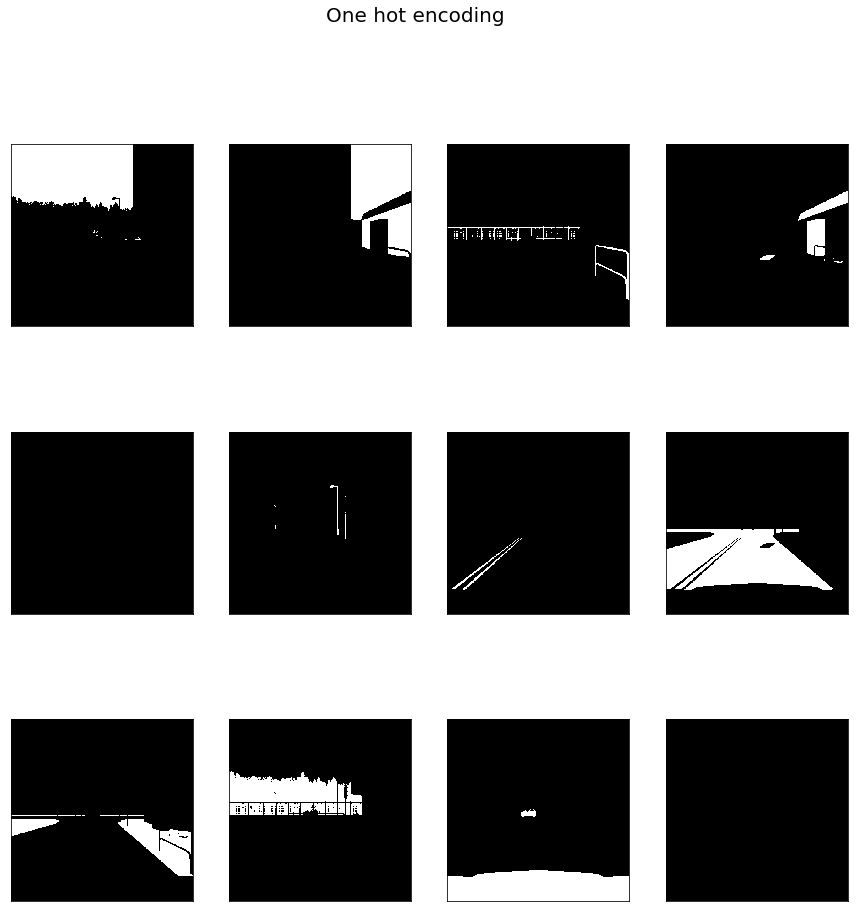

In [14]:
plt.figure(figsize=(15,15)).suptitle('One hot encoding', fontsize=20)
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(targets_oneHot[0][:,:,i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

## Creacion del modelo de red neuronal convolucional

In [15]:
from keras.models import Sequential
from keras.layers.core import Reshape
from keras.layers import Layer, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D

In [16]:
def segnet(num_classes, ksize=3, height=512, width=512, pool_size=2):
    
    cnn = Sequential()
    
    # Codificador
    cnn.add(Conv2D(64, (ksize, ksize), padding='same', input_shape=(height, width, 3)))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(64, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    cnn.add(Conv2D(128, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(128, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    cnn.add(Conv2D(256, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(256, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(256, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    cnn.add(Conv2D(512, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(512, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(512, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    cnn.add(Conv2D(512, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(512, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(512, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    # Decodificador
    cnn.add(UpSampling2D(size=(pool_size,pool_size)))
    cnn.add(Conv2D(512, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(512, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(512, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))

    cnn.add(UpSampling2D(size=(pool_size,pool_size)))
    cnn.add(Conv2D(512, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(512, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(256, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))


    cnn.add(UpSampling2D(size=(pool_size,pool_size)))
    cnn.add(Conv2D(256, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(256, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(128, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))

    cnn.add(UpSampling2D(size=(pool_size,pool_size)))
    cnn.add(Conv2D(128, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(64, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))

    cnn.add(UpSampling2D(size=(pool_size,pool_size)))
    cnn.add(Conv2D(64, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(num_classes, (ksize, ksize), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))

    cnn.add(Reshape((height*width , num_classes)))

    # Capa de clasificacion
    cnn.add(Activation('softmax'))

    cnn.add(Reshape((height, width , num_classes)))
    
    return cnn

In [17]:
cnn = segnet(13, ksize=3)

In [18]:
# Compilacion del modelo
cnn.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [19]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 512, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 512, 512, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 512, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 512, 512, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      0         
__________

In [ ]:
history = cnn.fit(data_imgs, targets_oneHot, validation_split=0.15, batch_size=1, epochs=20)

Train on 2975 samples, validate on 525 samples
Epoch 1/20
2975/2975 [==============================] - 1908s 641ms/step - loss: 0.5758 - acc: 0.8679 - val_loss: 0.5124 - val_acc: 0.8526
Epoch 2/20
2975/2975 [==============================] - 1897s 638ms/step - loss: 0.2757 - acc: 0.9263 - val_loss: 0.4320 - val_acc: 0.8709
Epoch 3/20
2975/2975 [==============================] - 1904s 640ms/step - loss: 0.2190 - acc: 0.9371 - val_loss: 0.3938 - val_acc: 0.8837
Epoch 4/20
2975/2975 [==============================] - 1900s 639ms/step - loss: 0.1885 - acc: 0.9428 - val_loss: 0.5198 - val_acc: 0.8580
Epoch 5/20
2975/2975 [==============================] - 1901s 639ms/step - loss: 0.1702 - acc: 0.9462 - val_loss: 0.4037 - val_acc: 0.8827
Epoch 6/20
2975/2975 [==============================] - 1905s 640ms/step - loss: 0.1546 - acc: 0.9495 - val_loss: 0.5752 - val_acc: 0.8516
Epoch 7/20
2975/2975 [==============================] - 1897s 638ms/step - loss: 0.1438 - acc: 0.9517 - val_loss: 0.392